Hands-on Image Processing with Python

Chapter 7: Extracting Image Features and Descriptors

Author: Sandipan Dey

### Import libraries

In [1]:
% matplotlib inline
from matplotlib import pylab as pylab
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.transform import warp, SimilarityTransform, AffineTransform, resize
import cv2
import numpy as np
from skimage import data
from skimage.util import img_as_float
from skimage.exposure import rescale_intensity
from skimage.measure import ransac

### Harris Corner Detector With scikit-image

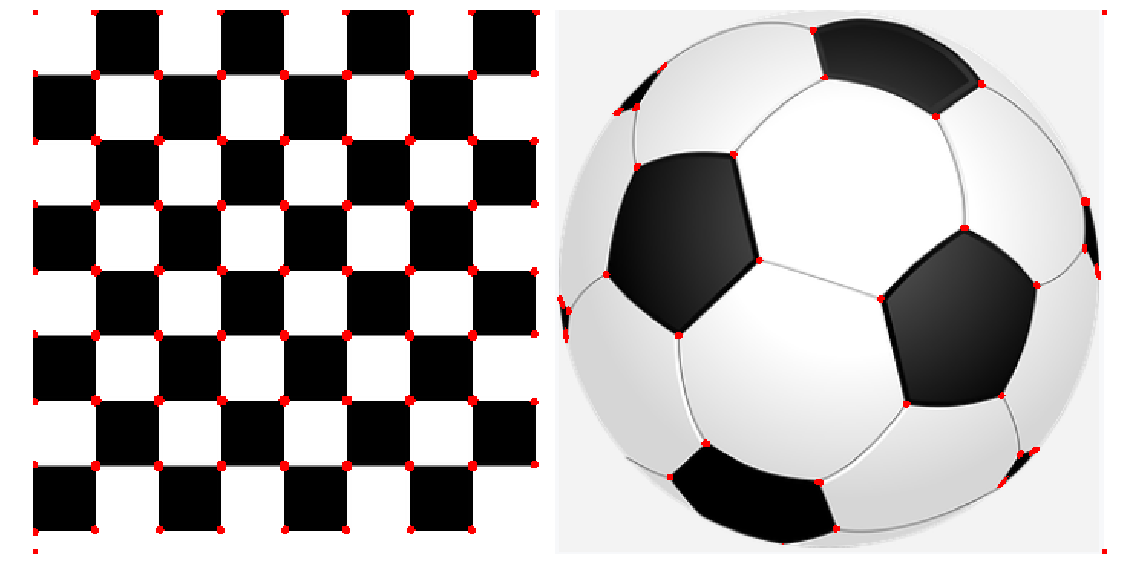

(<matplotlib.image.AxesImage at 0x202e06905f8>,
 (-0.5, 700.5, 354.5, -0.5),
 None)

In [23]:
image = imread('../images/chess_football.png') # RGB image
image_gray = rgb2gray(image)
coordinates = corner_harris(image_gray, k =0.001)
image[coordinates>0.01*coordinates.max()]=[255,0,0,255]
pylab.figure(figsize=(20,10))
pylab.imshow(image), pylab.axis('off'), pylab.show()

### With sub-pixel accuracy

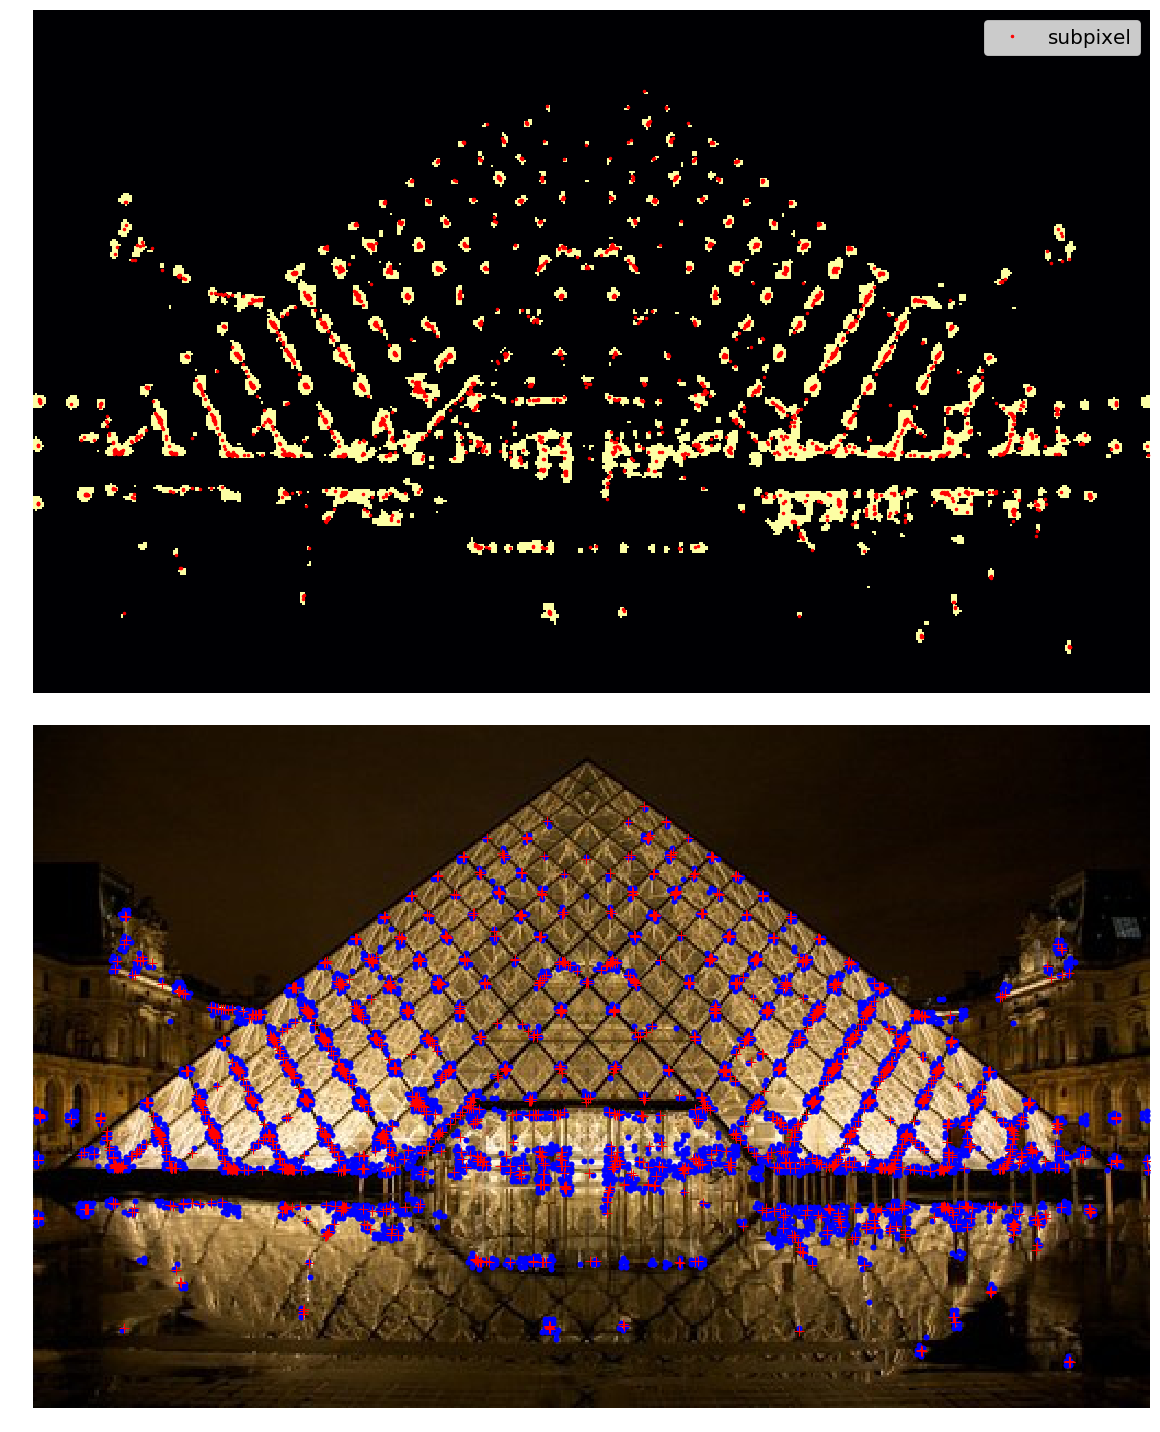

(None, None)

In [24]:
image = imread('../images/pyramids2.jpg')
image_gray = rgb2gray(image)
coordinates = corner_harris(image_gray, k =0.001)
coordinates[coordinates > 0.03*coordinates.max()] = 255 # threshold for an optimal value, depends on the image
corner_coordinates = corner_peaks(coordinates)
coordinates_subpix = corner_subpix(image_gray, corner_coordinates, window_size=11)
pylab.figure(figsize=(20,20))
pylab.subplot(211), pylab.imshow(coordinates, cmap='inferno')
pylab.plot(coordinates_subpix[:, 1], coordinates_subpix[:, 0], 'r.', markersize=5, label='subpixel')
pylab.legend(prop={'size': 20}), pylab.axis('off')
pylab.subplot(212), pylab.imshow(image, interpolation='nearest')
pylab.plot(corner_coordinates[:, 1], corner_coordinates[:, 0], 'bo', markersize=5)
pylab.plot(coordinates_subpix[:, 1], coordinates_subpix[:, 0], 'r+', markersize=10), pylab.axis('off')
pylab.tight_layout(), pylab.show()

### Robust image matching using the RANSAC algorithm and Harris Corner features 

In [25]:
temple = rgb2gray(img_as_float(imread('../images/temple.jpg')))
image_original = np.zeros(list(temple.shape) + [3])
image_original[..., 0] = temple
gradient_row, gradient_col = (np.mgrid[0:image_original.shape[0], 0:image_original.shape[1]] / float(image_original.shape[0]))
image_original[..., 1] = gradient_row
image_original[..., 2] = gradient_col
image_original = rescale_intensity(image_original)
image_original_gray = rgb2gray(image_original)
affine_trans = AffineTransform(scale=(0.8, 0.9), rotation=0.1, translation=(120, -20))
image_warped = warp(image_original, affine_trans .inverse, output_shape=image_original.shape)
image_warped_gray = rgb2gray(image_warped)
coordinates = corner_harris(image_original_gray)
coordinates[coordinates > 0.01*coordinates.max()] = 1
coordinates_original = corner_peaks(coordinates, threshold_rel=0.0001, min_distance=5)
coordinates = corner_harris(image_warped_gray)
coordinates[coordinates > 0.01*coordinates.max()] = 1
coordinates_warped = corner_peaks(coordinates, threshold_rel=0.0001, min_distance=5)
coordinates_original_subpix = corner_subpix(image_original_gray, coordinates_original, window_size=9)
coordinates_warped_subpix = corner_subpix(image_warped_gray, coordinates_warped, window_size=9)

In [26]:
def gaussian_weights(window_ext, sigma=1):
    y, x = np.mgrid[-window_ext:window_ext+1, -window_ext:window_ext+1]
    g_w = np.zeros(y.shape, dtype = np.double)
    g_w[:] = np.exp(-0.5 * (x**2 / sigma**2 + y**2 / sigma**2))
    g_w /= 2 * np.pi * sigma * sigma
    return g_w

In [27]:
def match_corner(coordinates, window_ext=3):
    row, col = np.round(coordinates).astype(np.intp)
    window_original = image_original[row-window_ext:row+window_ext+1, col-window_ext:col+window_ext+1, :]
    weights = gaussian_weights(window_ext, 3)
    weights = np.dstack((weights, weights, weights))
    SSDs = []
    for coord_row, coord_col in coordinates_warped:
        window_warped = image_warped[coord_row-window_ext:coord_row+window_ext+1,
        coord_col-window_ext:coord_col+window_ext+1, :]
        if window_original.shape == window_warped.shape:
            SSD = np.sum(weights * (window_original - window_warped)**2)
            SSDs.append(SSD)
    min_idx = np.argmin(SSDs) if len(SSDs) > 0 else -1
    return coordinates_warped_subpix[min_idx] if min_idx >= 0 else [None]

In [28]:
from skimage.feature import (match_descriptors, corner_peaks, corner_harris, plot_matches, BRIEF)
source, destination = [], []
for coordinates in coordinates_original_subpix:
    coordinates1 = match_corner(coordinates)
    if any(coordinates1) and len(coordinates1) > 0 and not all(np.isnan(coordinates1)):
        source.append(coordinates)
        destination.append(coordinates1)
source = np.array(source)
destination = np.array(destination)
model = AffineTransform()
model.estimate(source, destination)
model_robust, inliers = ransac((source, destination), AffineTransform, min_samples=3, residual_threshold=2, max_trials=100)
outliers = inliers == False
print(affine_trans.scale, affine_trans.translation, affine_trans.rotation)
print(model.scale, model.translation, model.rotation)
print(model_robust.scale, model_robust.translation, model_robust.rotation)

C:\Users\Sandipan.Dey\Anaconda\envs\ana41py35\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in longlong_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


(0.8, 0.9) [120. -20.] 0.09999999999999999
(0.8982412101241938, 0.8072777593937368) [-20.45123966 114.92297156] -0.10225420334222493
(0.9001524425730122, 0.8000362790749186) [-19.87491292 119.83016533] -0.09990858564132554


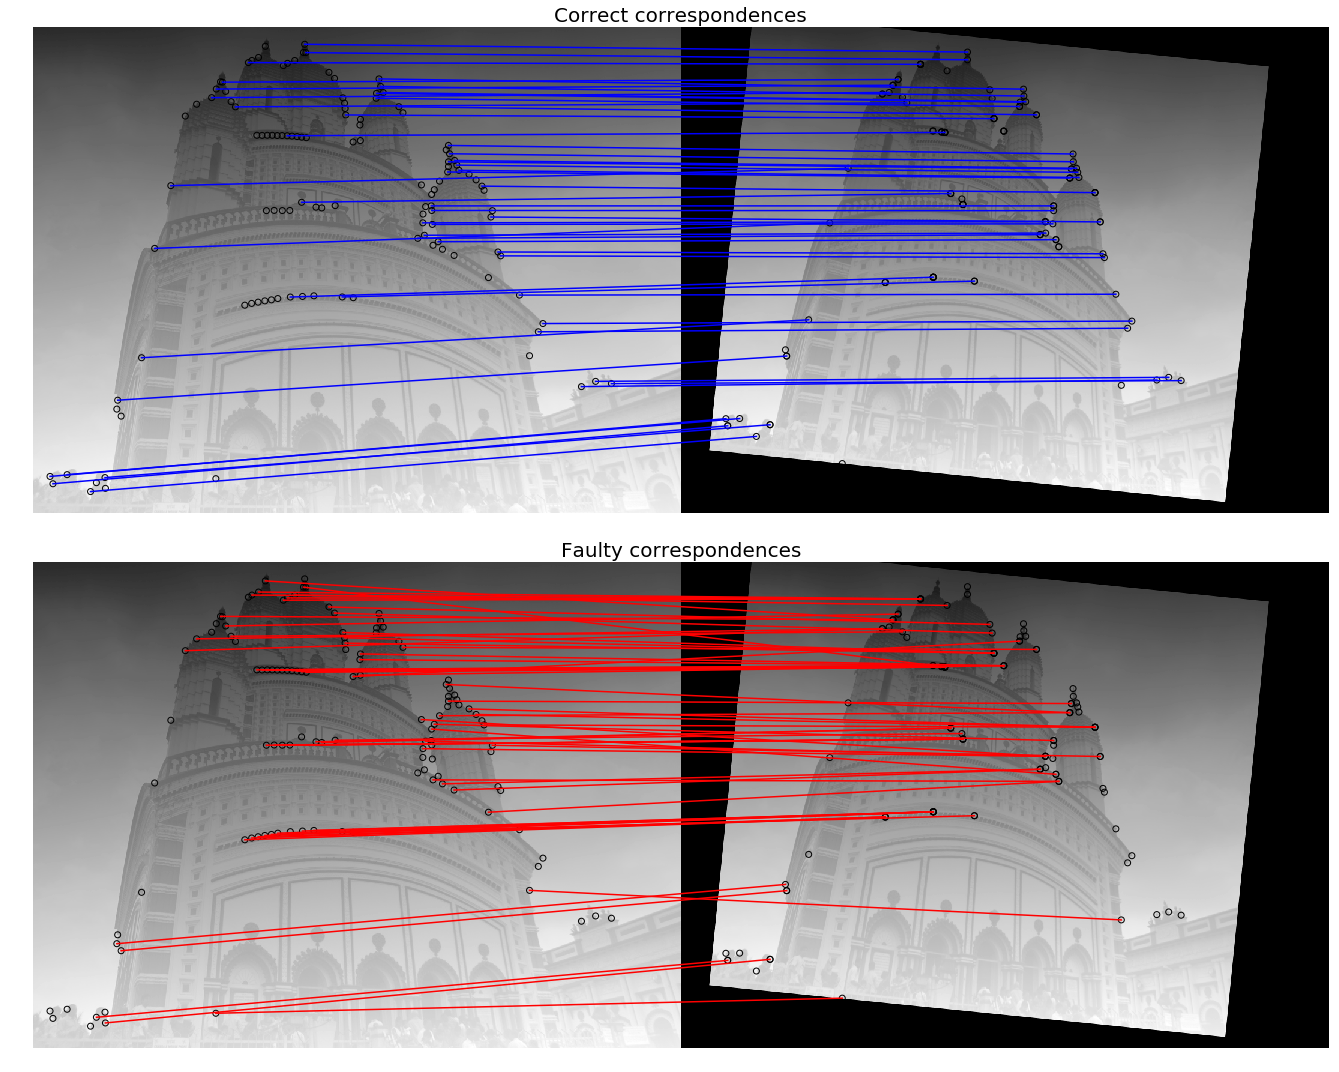

(None, None)

In [31]:
fig, axes = pylab.subplots(nrows=2, ncols=1, figsize=(20,15))
pylab.gray()
inlier_idxs = np.nonzero(inliers)[0]
plot_matches(axes[0], image_original_gray, image_warped_gray, source, destination, np.column_stack((inlier_idxs, inlier_idxs)),matches_color='b')
axes[0].axis('off'), axes[0].set_title('Correct correspondences', size=20)
outlier_idxs = np.nonzero(outliers)[0]
plot_matches(axes[1], image_original_gray, image_warped_gray, source, destination, np.column_stack((outlier_idxs, outlier_idxs)), matches_color='r')
axes[1].axis('off'), axes[1].set_title('Faulty correspondences', size=20)
fig.tight_layout(), pylab.show()

### Blob detectors with LoG, DoG and DoH

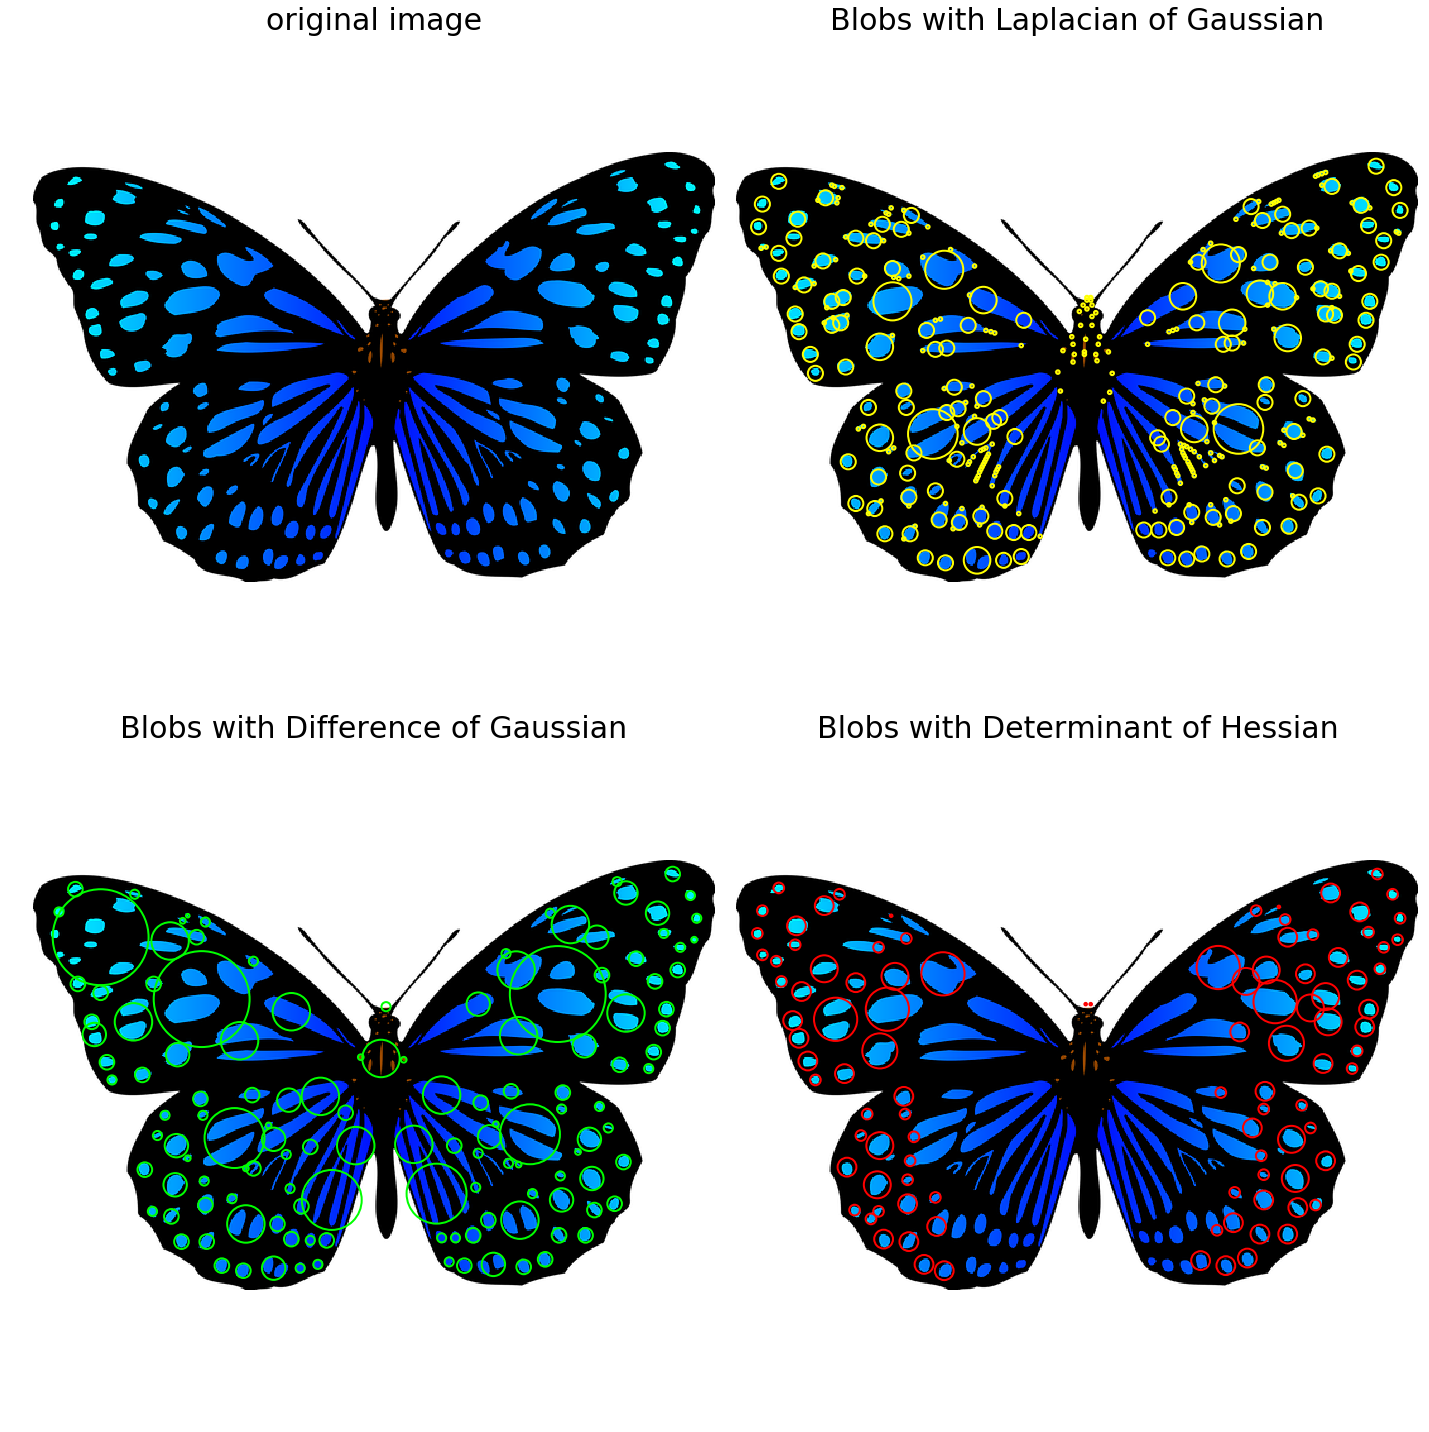

(None, None)

In [33]:
from numpy import sqrt
from skimage.feature import blob_dog, blob_log, blob_doh
im = imread('../images/butterfly.png')
im_gray = rgb2gray(im)
log_blobs = blob_log(im_gray, max_sigma=30, num_sigma=10, threshold=.1)
log_blobs[:, 2] = sqrt(2) * log_blobs[:, 2] # Compute radius in the 3rd column
dog_blobs = blob_dog(im_gray, max_sigma=30, threshold=0.1)
dog_blobs[:, 2] = sqrt(2) * dog_blobs[:, 2]
doh_blobs = blob_doh(im_gray, max_sigma=30, threshold=0.005)
list_blobs = [log_blobs, dog_blobs, doh_blobs]
colors, titles = ['yellow', 'lime', 'red'], ['Laplacian of Gaussian', 'Difference of Gaussian', 'Determinant of Hessian']
sequence = zip(list_blobs, colors, titles)
fig, axes = pylab.subplots(2, 2, figsize=(20, 20), sharex=True, sharey=True)
axes = axes.ravel()
axes[0].imshow(im, interpolation='nearest')
axes[0].set_title('original image', size=30), axes[0].set_axis_off()
for idx, (blobs, color, title) in enumerate(sequence):
    axes[idx+1].imshow(im, interpolation='nearest')
    axes[idx+1].set_title('Blobs with ' + title, size=30)
    for blob in blobs:
        y, x, row = blob
        col = pylab.Circle((x, y), row, color=color, linewidth=2, fill=False)
        axes[idx+1].add_patch(col), axes[idx+1].set_axis_off()
pylab.tight_layout(), pylab.show()

### Compute HOG descriptors with scikit-image

C:\Users\Sandipan.Dey\Anaconda\envs\ana41py35\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


(256, 256) 2048


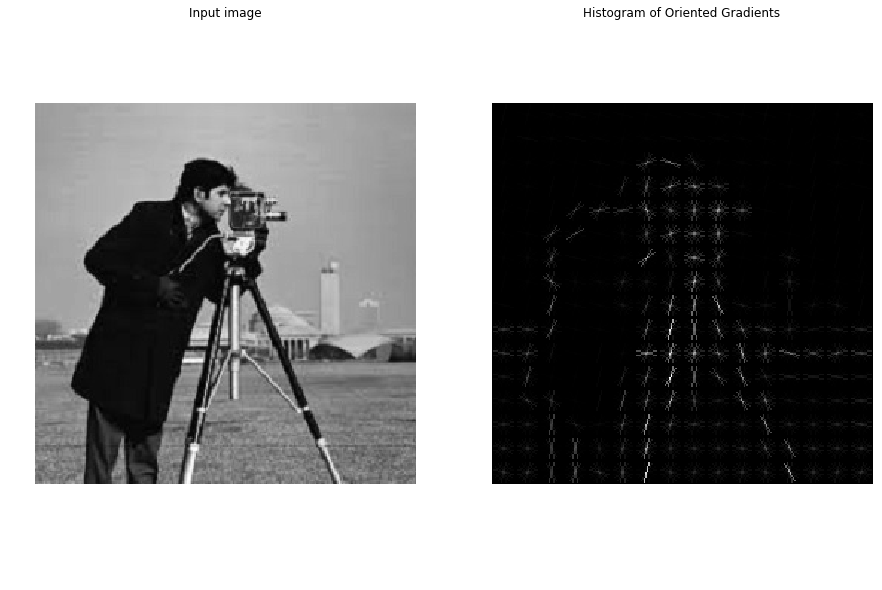

In [36]:
from skimage.feature import hog
from skimage import exposure
image = rgb2gray(imread('../images/cameraman.jpg'))
fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
cells_per_block=(1, 1), visualize=True)
print(image.shape, len(fd))
# ((256L, 256L), 2048)
fig, (axes1, axes2) = pylab.subplots(1, 2, figsize=(15, 10), sharex=True, sharey=True)
axes1.axis('off'), axes1.imshow(image, cmap=pylab.cm.gray), axes1.set_title('Input image')
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
axes2.axis('off'), axes2.imshow(hog_image_rescaled, cmap=pylab.cm.gray),
axes2.set_title('Histogram of Oriented Gradients')
pylab.show()

### Scale-invariant feature transform (SIFT)

In [5]:
# make sure the opencv version is 3.3.0 with pip install opencv-python==3.3.0.10 opencv-contrib-python==3.3.0.10
import cv2
print(cv2.__version__)
# 3.3.0
img = cv2.imread('../images/monalisa.jpg')
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(gray,None) # detect SIFT keypoints
img = cv2.drawKeypoints(img,kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imwrite('../images/me5_keypoints.jpg',img)
kp, des = sift.detectAndCompute(gray,None) # compute the SIFT descriptor

3.3.0


### Matching images with BRIEF binary descriptors with scikit-image

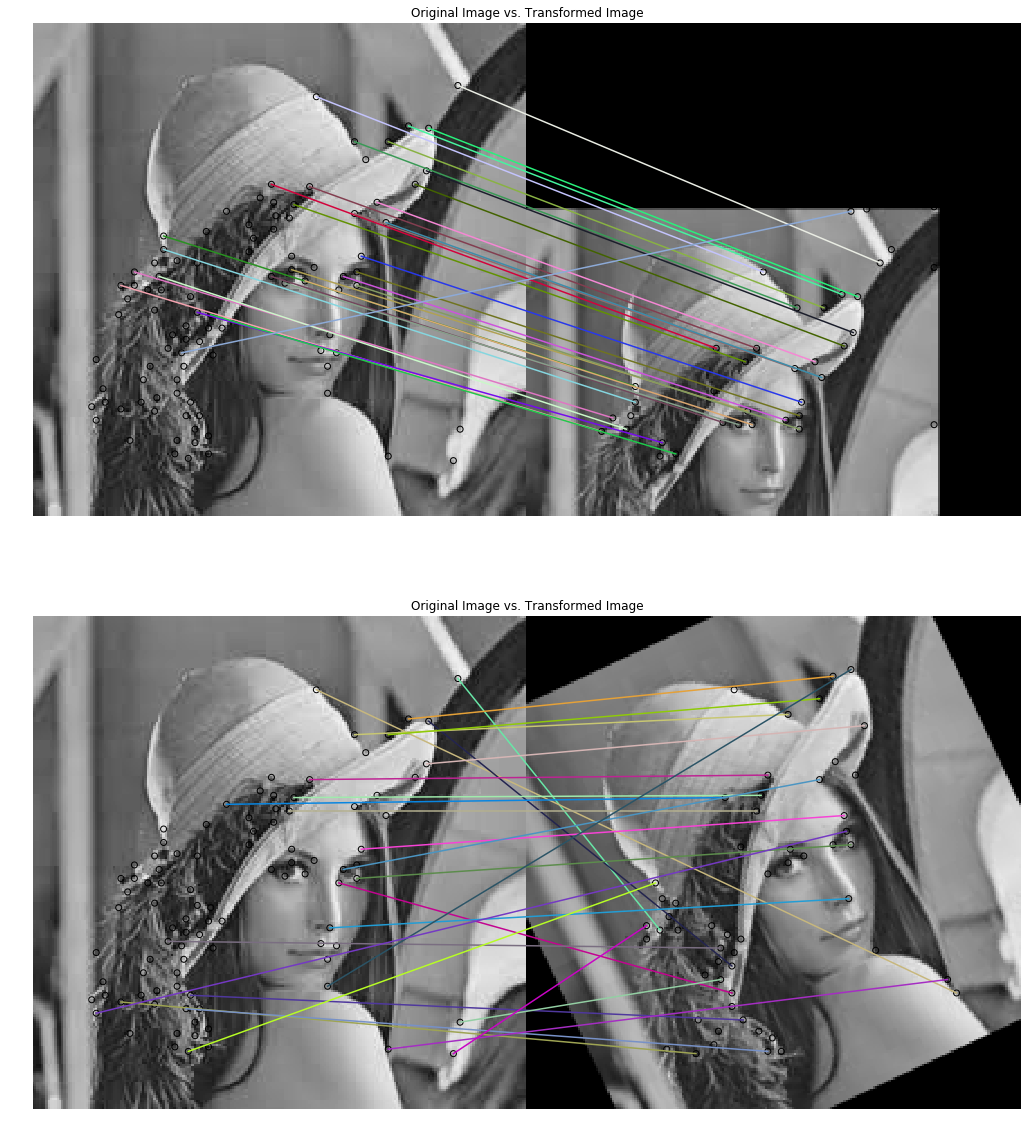

((0.0, 440.0, 220.0, 0.0), <matplotlib.text.Text at 0x202e85484a8>, None)

In [46]:
from skimage import transform as transform
from skimage.feature import (match_descriptors, corner_peaks, corner_harris, plot_matches, BRIEF)
img1 = rgb2gray(imread('../images/lena.jpg')) #data.astronaut())
affine_trans = transform.AffineTransform(scale=(1.2, 1.2), translation=(0,-100))
img2 = transform.warp(img1, affine_trans)
img3 = transform.rotate(img1, 25)
coords1, coords2, coords3 = corner_harris(img1), corner_harris(img2), corner_harris(img3)
coords1[coords1 > 0.01*coords1.max()] = 1
coords2[coords2 > 0.01*coords2.max()] = 1
coords3[coords3 > 0.01*coords3.max()] = 1
keypoints1 = corner_peaks(coords1, min_distance=5)
keypoints2 = corner_peaks(coords2, min_distance=5)
keypoints3 = corner_peaks(coords3, min_distance=5)
extractor = BRIEF()
extractor.extract(img1, keypoints1)
keypoints1, descriptors1 = keypoints1[extractor.mask], extractor.descriptors
extractor.extract(img2, keypoints2)
keypoints2, descriptors2 = keypoints2[extractor.mask], extractor.descriptors
extractor.extract(img3, keypoints3)
keypoints3, descriptors3 = keypoints3[extractor.mask], extractor.descriptors
matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)
matches13 = match_descriptors(descriptors1, descriptors3, cross_check=True)
fig, axes = pylab.subplots(nrows=2, ncols=1, figsize=(20,20))
pylab.gray(), plot_matches(axes[0], img1, img2, keypoints1, keypoints2, matches12)
axes[0].axis('off'), axes[0].set_title("Original Image vs. Transformed Image")
plot_matches(axes[1], img1, img3, keypoints1, keypoints3, matches13)
axes[1].axis('off'), axes[1].set_title("Original Image vs. Transformed Image"), pylab.show()

### Matching with ORB feature detector and binary descriptor using scikit-image

C:\Users\Sandipan.Dey\Anaconda\envs\ana41py35\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


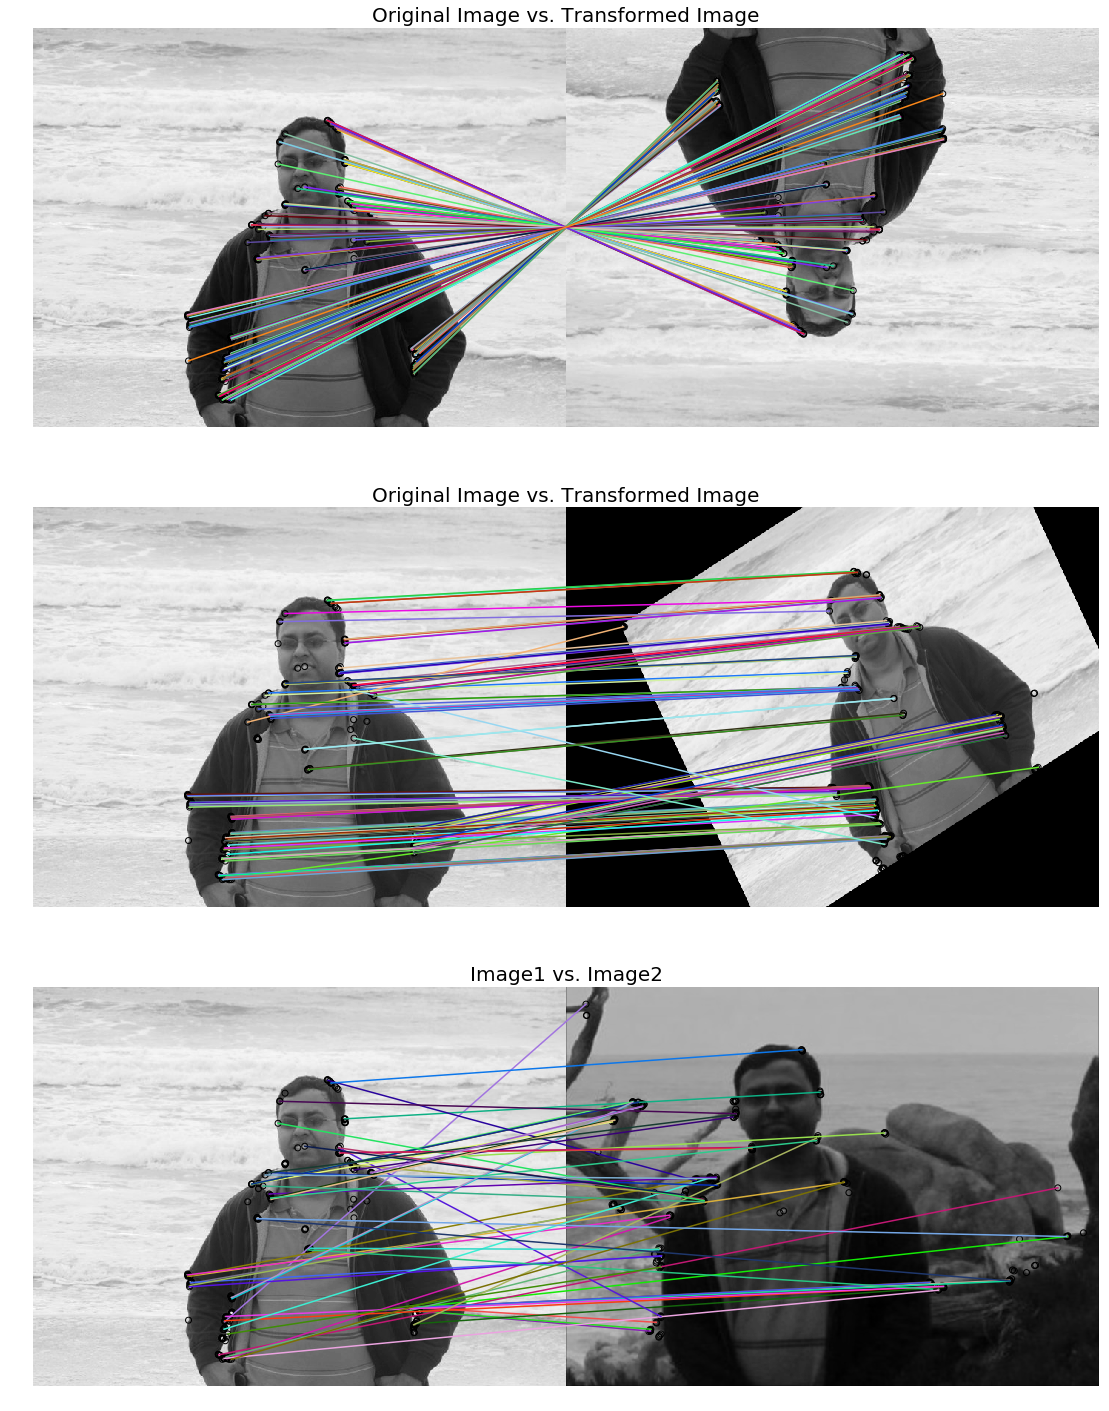

In [52]:
from skimage import transform as transform
from skimage.feature import (match_descriptors, ORB, plot_matches)
img1 = rgb2gray(imread('../images/me5.jpg'))
img2 = transform.rotate(img1, 180)
affine_trans = transform.AffineTransform(scale=(1.3, 1.1), rotation=0.5, translation=(0, -200))
img3 = transform.warp(img1, affine_trans)
img4 = transform.resize(rgb2gray(imread('../images/me6.jpg')), img1.shape, anti_aliasing=True)
descriptor_extractor = ORB(n_keypoints=200)
descriptor_extractor.detect_and_extract(img1)
keypoints1, descriptors1 = descriptor_extractor.keypoints, descriptor_extractor.descriptors
descriptor_extractor.detect_and_extract(img2)
keypoints2, descriptors2 = descriptor_extractor.keypoints, descriptor_extractor.descriptors
descriptor_extractor.detect_and_extract(img3)
keypoints3, descriptors3 = descriptor_extractor.keypoints, descriptor_extractor.descriptors
descriptor_extractor.detect_and_extract(img4)
keypoints4, descriptors4 = descriptor_extractor.keypoints, descriptor_extractor.descriptors
matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)
matches13 = match_descriptors(descriptors1, descriptors3, cross_check=True)
matches14 = match_descriptors(descriptors1, descriptors4, cross_check=True)
fig, axes = pylab.subplots(nrows=3, ncols=1, figsize=(20,25))
pylab.gray()
plot_matches(axes[0], img1, img2, keypoints1, keypoints2, matches12)
axes[0].axis('off'), axes[0].set_title("Original Image vs. Transformed Image", size=20)
plot_matches(axes[1], img1, img3, keypoints1, keypoints3, matches13)
axes[1].axis('off'), axes[1].set_title("Original Image vs. Transformed Image", size=20)
plot_matches(axes[2], img1, img4, keypoints1, keypoints4, matches14)
axes[2].axis('off'), axes[2].set_title("Image1 vs. Image2", size=20)
pylab.show()

### Matching with ORB features using Brute-Force matching with python-opencv

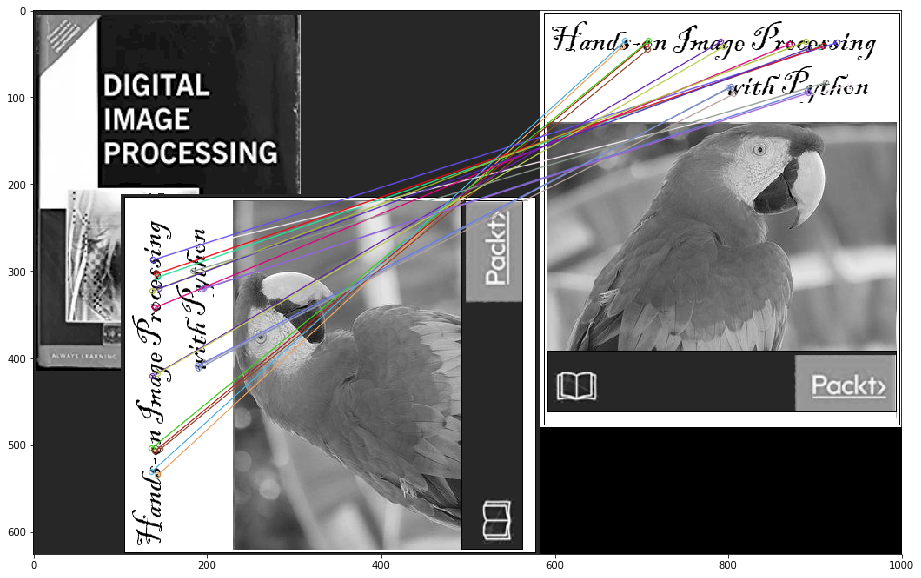

(<matplotlib.figure.Figure at 0x202ea26ff28>,
 None)

In [57]:
img1 = cv2.imread('../images/books.png',0) # queryImage
img2 = cv2.imread('../images/book.png',0) # trainImage
# Create a ORB detector object
orb = cv2.ORB_create()
# find the keypoints and descriptors
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)
# create a BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1, des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# Draw first 20 matches.
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:20], None, flags=2)
pylab.figure(figsize=(20,10)), pylab.imshow(img3), pylab.show()

### Brute-force matching with SIFT descriptors and ratio test with OpenCV

3.3.0


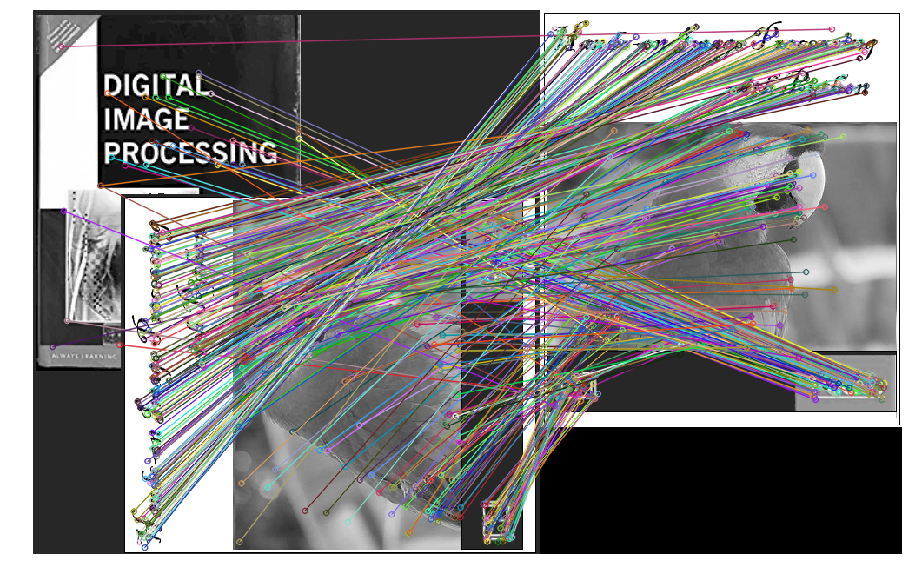

(<matplotlib.figure.Figure at 0x2542c33a7f0>,
 (-0.5, 999.5, 625.5, -0.5),
 None)

In [3]:
# make sure the opencv version is 3.3.0 with pip install opencv-python==3.3.0.10 opencv-contrib-python==3.3.0.10
import cv2
print(cv2.__version__)
# 3.3.0
img1 = cv2.imread('../images/books.png',0) # queryImage
img2 = cv2.imread('../images/book.png',0) # trainImage
# Create a SIFT detector object
sift = cv2.xfeatures2d.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)
# Apply ratio test
good_matches = []
for m1, m2 in matches:
    if m1.distance < 0.75*m2.distance:
        good_matches.append([m1])
img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2,good_matches, None, flags=2)
pylab.figure(figsize=(20,10)), pylab.imshow(img3), pylab.axis('off'), pylab.show()

### Haar-like feature descriptor with scikit-image

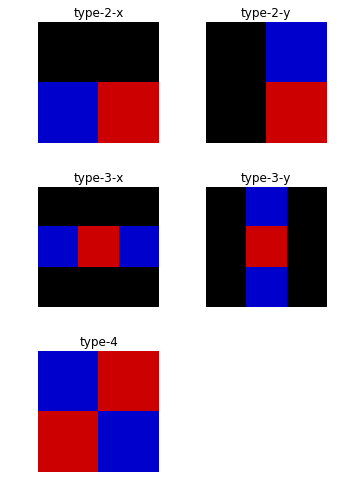

((0.0, 1.0, 0.0, 1.0), None, None)

In [64]:
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature
images = [np.zeros((2, 2)), np.zeros((2, 2)), np.zeros((3, 3)),
np.zeros((3, 3)), np.zeros((2, 2))]
feature_types = ['type-2-x', 'type-2-y', 'type-3-x', 'type-3-y', 'type-4']
fig, axes = pylab.subplots(3, 2, figsize=(5,7))
for axes, img, feat_t in zip(np.ravel(axes), images, feature_types):
    coordinates, _ = haar_like_feature_coord(img.shape[0], img.shape[1], feat_t)
    haar_feature = draw_haar_like_feature(img, 0, 0, img.shape[0],img.shape[1], coordinates, max_n_features=1, random_state=0, color_positive_block=(1.0, 0.0, 0.0), color_negative_block=(0.0, 0.0, 1.0), alpha=0.8)
    axes.imshow(haar_feature), axes.set_title(feat_t), axes.set_axis_off()
#fig.suptitle('Different Haar-like feature descriptors')
pylab.axis('off'), pylab.tight_layout(), pylab.show()

### Face/eye detection with OpenCV using pre-trained classifiers with Haar-cascade features

In [66]:
opencv_haar_path = './' #'C:/opencv/data/haarcascades/' # provide proper opencv installation path
face_cascade = cv2.CascadeClassifier(opencv_haar_path + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(opencv_haar_path + 'haarcascade_eye.xml')
#eye_cascade = cv2.CascadeClassifier(opencv_haar_path + 'haarcascade_eye_tree_eyeglasses.xml') # eye with glasses

In [69]:
img = cv2.imread('../images/lena.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.2, 5) # scaleFactor=1.2, minNbr=5
print(len(faces)) # number of faces detected
for (x,y,w,h) in faces:
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    print(eyes) # location of eyes detected
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        cv2.imwrite('../images/lena_face_detected.jpg', img)

1
[[11 14 23 23]
 [38 16 21 21]]
